<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Drift_Chambers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drift Chambers and Tracks**
---
Welcome to Particle Identification Playground! In this activity, you will get a brief introduction to drift chambers and tracks.

**Before attempting this notebook, complete all of the activities in the Getting Started section.**

**After completing this notebook, you will be able to:**
*   Describe the role of drift chambers in a particle detector
*   Define tracks and hits
*   Identify which particles leave tracks
*   Use individual hits to determine the position of a track
*   Find the momentum and charge of a particle based on the curvature of a track

In [1]:
#@title Run this cell before starting
from IPython.display import YouTubeVideo
import plotly.express as pxp
import pandas as pd
import numpy as np
import ipywidgets as widgets
import plotly
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, HBox, VBox, Layout
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from google.colab import output
import xml.etree.ElementTree as ET
import warnings
data =pd.DataFrame()
warnings.filterwarnings("ignore")
output.enable_custom_widget_manager()
!wget -q https://github.com/JeffersonLab/hdds/raw/master/CentralDC_HDDS.xml
!wget -q https://github.com/duberii/pid-playground/raw/main/data/track_fitting_events.hdf5
track_fitting_events = pd.read_hdf("track_fitting_events.hdf5","event1")
B = 1.7
tree =ET.parse("CentralDC_HDDS.xml")
root = tree.getroot()
n_wires_per_ring = [0]
wire_to_ring = [0]
positionsMatrix = []
ar = []

def degrees_to_radians(degrees):
  return degrees*np.pi/180

for tag in [j for j in root.findall("composition") if j.get("name")=="CDClayers"][0]:
  if tag.tag == "mposPhi":
    positionsMatrix.append([])
    n_wires_per_ring.append(int(tag.get('ncopy')))
    R_Z = float(tag.get("R_Z").split()[0])
    Phi0 = degrees_to_radians(float(tag.get("Phi0")))
    if tag.get("volume") == 'CDCstrawShort':
      dPhi = degrees_to_radians(float(tag.get("dPhi")))
      for i in range(int(tag.get("ncopy"))):
        ar.append({'pos':[[R_Z*np.cos(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi),0],[R_Z*np.cos(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi),150]],'ring':int(tag.find("ring").get("value")),'straw':i+1})
        positionsMatrix[-1].append(ar[-1]['pos'])
    if tag.get("volume") == 'CDCstrawLong':
      n_wires_per_ring.append(int(tag.get('ncopy')))
      dPhi = 2*np.pi/int(tag.get("ncopy"))
      rot = degrees_to_radians(float(tag.get('rot').split()[0]))
      for i in range(int(tag.get("ncopy"))):
        ar.append({'pos':[[R_Z*np.cos(Phi0+i*dPhi)+75*np.tan(rot)*np.sin(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi)-75*np.tan(rot)*np.cos(Phi0+i*dPhi),0],[R_Z*np.cos(Phi0+i*dPhi)-75*np.tan(rot)*np.sin(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi)+75*np.tan(rot)*np.cos(Phi0+i*dPhi),150]],'ring':int(tag.find("ring").get("value")),'straw':i+1})
        positionsMatrix[-1].append(ar[-1]['pos'])
wire_positions_df = pd.DataFrame.from_records(ar)

def x_coord(r_curvature, theta_curvature,center_x, t,q):
  return r_curvature*np.cos(theta_curvature-q*t) + center_x

def y_coord(r_curvature,theta_curvature,center_y, t,q):
  return r_curvature*np.sin(theta_curvature-q*t)+ center_y

def ring_wire_to_x_y(rings, wires,s, dataframe=False):
  if dataframe:
    df = pd.DataFrame()
    df['ring'] = rings
    df['wire'] = wires
    if not isinstance(s,float) and not isinstance(s, int):
      df['x'] = [positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][0]*(1-s[i]) + s[i]* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][0] for i in range(len(wires))]
      df['y'] = [positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][1]*(1-s[i]) + s[i]* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][1] for i in range(len(wires))]
    else:
      df['x'] = [positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][0]*(1-s) + s* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][0] for i in range(len(wires))]
      df['y'] = [positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][1]*(1-s) + s* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][1] for i in range(len(wires))]
    return df
  else:
    if not isinstance(s,float) and not isinstance(s, int):
      new_x = np.array([positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][0]*(1-s[i]) + s[i]* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][0] for i in range(len(wires))])
      new_y = np.array([positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][1]*(1-s[i]) + s[i]* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][1] for i in range(len(wires))])
    else:
      new_x = np.array([positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][0]*(1-s) + s* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][0] for i in range(len(wires))])
      new_y = np.array([positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][0][1]*(1-s) + s* positionsMatrix[int(rings[i]-1)][int(wires[i]-1)][1][1] for i in range(len(wires))])
    return new_x, new_y

def get_charge(ptype):
  if ptype in ["Electron", "Muon", "Pi-", "K-",'AntiProton']:
    return -1
  else:
    return 1

class CDC_plot():
  def __init__(self, title, event=0, showTrack = False, showHits = False, showlegend=False):
    self.figure = go.FigureWidget()
    self.figure.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=500,height=500,showlegend=showlegend,title=title,xaxis_title="X", yaxis_title="Y")
    self.figure.add_shape(type="circle", xref="x", yref="y", x0=-10.5, y0=-10.5, x1=10.5, y1=10.5, line_color="black")
    self.figure.add_shape(type="circle", xref="x", yref="y", x0=-55, y0=-55, x1=55, y1=55, line_color="black")
    if not isinstance(event, int):
      showHits = True
      self.charge = get_charge(event["particle"])
      self.px = event['px']
      self.py = event['py']
      self.pz = event['pz']
      self.vz = event['vz']
      self.ring = event['ring']
      self.straw = event['straw']
      df = ring_wire_to_x_y(self.ring,self.straw,75,dataframe=True)
      self.figure.add_scatter(x=df['x'].to_numpy(),y=df['y'].to_numpy(),mode='markers',text = ["Ring: " + str(row['ring']) + "\n Wire: " + str(row['wire']) for row in df.iloc],hoverinfo='text',marker={"size":3})
    if showTrack:
      self.figure.add_scatter(mode='lines',name='track',marker={"color":'red'})
  def show(self):
    self.figure.show()
  def update_layout(self, *args, **kwargs):
    self.figure.update_layout(*args, **kwargs)
  def update(self, *args, **kwargs):
    self.figure.update(*args, **kwargs)
  def display(self,*args,**kwargs):
    widget=interactive(*args,**kwargs)
    controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
    output = widget.children[-1]
    display(VBox([controls, output]))
  def update_figure(self, z0=0,px=0,py=0,charge=1,pz=0,t_max = np.pi, show_track = True, show_hits = True):
    B=1.7
    p = (px**2 + py**2 + pz**2)**0.5
    try:
      z_angle = np.arcsin(pz/p)
    except:
      z_angle = 0
    center_x = charge*330*py/B
    center_y = -1*charge*330*px/B
    r_curvature = (center_x**2 + center_y**2)**0.5
    theta_curvature = np.arctan2(-1*center_y,-1*center_x)
    if show_hits:
      new_x,new_y = ring_wire_to_x_y(self.ring,self.straw,z0/175)
      theta_hits= np.arctan2(new_y-center_y,new_x-center_x)
      for i in range(len(theta_hits)):
        theta_hits[i]-= theta_curvature
        theta_hits[i] = theta_hits[i] * -1 * charge
        if theta_hits[i] <0:
          theta_hits[i] += 2*np.pi
      for i in range(len(self.ring)):
        new_x,new_y = ring_wire_to_x_y(self.ring,self.straw,[(z0 +r_curvature*theta_hits[i]*np.tan(z_angle))/175 for i in range(len(self.ring))])
    if show_track:
      t_curve = np.linspace(0,t_max,1000)
      x_track = x_coord(r_curvature,theta_curvature,center_x,t_curve,charge)
      y_track = y_coord(r_curvature,theta_curvature,center_y,t_curve,charge)
    with fig.figure.batch_update():
      if show_track:
        fig.figure.data[len(fig.figure.data)-1]['x']=x_track
        fig.figure.data[len(fig.figure.data)-1]['y']=y_track
      fig.update_layout(width=500,height=500,showlegend=False)
      if show_hits:
        fig.figure.data[0]['x']=new_x
        fig.figure.data[0]['y']=new_y
    fig.show()
  def distance_to_curve(self,x,y):
    center_x = self.charge*330*self.py/1.7
    center_y = -330*self.charge*self.px/1.7
    r_curvature = (center_x**2 + center_y**2)**0.5
    distance_to_nearest_curve_point = abs(r_curvature-((x-center_x)**2+(y-center_y)**2)**0.5)
    return distance_to_nearest_curve_point
  def calculate_rmse(self,x_points, y_points):
    mse = sum([self.distance_to_curve(x_points[j],y_points[j])**2 for j in range(len(x_points))])/len(x_points)
    rmse = mse**0.5
    return rmse
  def calc_z0(self, quiet=False, return_rmse=False):
    rmses = {}
    center_x = self.charge*330*self.py/B
    center_y = -330*self.charge*self.px/B
    for z in np.linspace(0,150,151):
      new_x, new_y = ring_wire_to_x_y(self.ring, self.straw,z/175)
      rmses[z] = self.calculate_rmse(new_x,new_y)
    if quiet and return_rmse:
      return min(rmses, key=rmses.get), min(list(rmses.values()))
    elif quiet:
      return min(rmses, key=rmses.get)
    elif return_rmse:
      min(list(rmses.values()))
    else:
      print("The true z value is about " + str(min(rmses, key=rmses.get)))

  def show_answer(self, charge=True,px=True,py=True,pz=False,z0=False,but="", every=False):
    if z0 or all([every,but != "z0"]):
      self.calc_z0()
    if charge or all([every,but != "charge"]):
      print("The charge of the particle is " + str(self.charge))
    if px or all([every,but != "px"]):
      print("The x component of momentum is " + str(round(self.px, 2)))
    if py or all([every,but != "py"]):
      print("The y component of momentum is " + str(round(self.py, 2)))
    if pz or all([every,but != "pz"]):
      print("The z component of momentum is " + str(round(self.pz, 2)))

class wire_plot():
  def __init__(self,rings,title, showlegend=True):
    self.figure = go.FigureWidget()
    self.figure.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=500,height=500,showlegend=showlegend,title=title,xaxis_title="X", yaxis_title="Y")
    self.figure.add_shape(type="circle", xref="x", yref="y", x0=-10.5, y0=-10.5, x1=10.5, y1=10.5, line_color="black")
    self.figure.add_shape(type="circle", xref="x", yref="y", x0=-55, y0=-55, x1=55, y1=55, line_color="black")
    for ring in rings:
      self.figure.add_scatter(mode='markers',name="Ring " + str(ring),marker={"size":3},hoverinfo='text',text = ['Ring: ' + str(ring) + "\n Wire: " + str(k) for k in range(len(positionsMatrix[int(ring)-1]))])
    self.data = []
  def show(self):
    self.figure.show()
  def update_layout(self, *args, **kwargs):
    self.figure.update_layout(*args, **kwargs)
  def update(self, *args, **kwargs):
    self.figure.update(*args, **kwargs)
  def display(self,*args,**kwargs):
    widget=interactive(*args,**kwargs)
    controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
    output = widget.children[-1]
    display(VBox([controls, output]))
  def update_figure(self,z=0, rings=[]):
    s= z/175
    with fig.figure.batch_update():
      for i in range(len(rings)):
        fig.figure.data[i]['x']=[(1-s)*wire[0][0]+ s*wire[1][0] for wire in positionsMatrix[int(rings[i])-1]]
        fig.figure.data[i]['y']=[(1-s)*wire[0][1]+ s*wire[1][1] for wire in positionsMatrix[int(rings[i])-1]]
    fig.show()

---
##**Tracking Detectors**
---
**Silicon Trackers** and **Drift Chambers** are the two most common detectors that are able to measure momentum. Both of these detectors use the fact that charged particles can ionize atoms, . In this activity, we will explore drift chambers.

The most important concept for momentum detectors is the idea of a **track**. A track is the path left as a charged particle passes through a momentum detector. When we observe a track in a detector, we know that there must be some particle that left that track, and our goal is to use information from the various detectors to identify the properties of that particle.

Any detector that relies on the production of tracks is called a **Tracking Detector**.

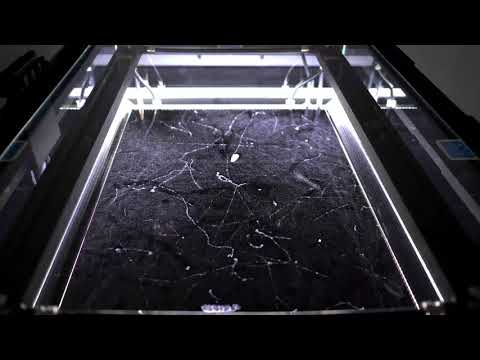

In [2]:
# @title
YouTubeVideo(width = 560, height = 315, id="i15ef618DP0")

This video is a recording of one of the first types of tracking detectors called a **cloud chamber**. Each of those puffs of smoke is a track left by a charged particle passing through the detector. This type of detector was the inspiration for the background of the [PID Playground homepage](https://duberii.github.io/pid-playground)!


---
##**Drift Chambers**
---
Drift Chambers (as well as cloud chambers and silicon trackers) at their core are just boxes of gas with a grid of wires in them. These wires are extremely close to each other, often to the point where it looks like they touch (even though they do not). The GlueX detector uses a slightly modified detector called a **Straw Chamber**, which has a slightly different layout, with positively charged wires inside negatively charged tubes.

<img width="512" alt="An image of a small piece of a drift chamber" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Chambre-a-derive-IMG_0524.jpg/512px-Chambre-a-derive-IMG_0524.jpg"><br>
<a href="https://commons.wikimedia.org/wiki/File:Chambre-a-derive-IMG_0524.jpg">Rama</a>, <a href="https://creativecommons.org/licenses/by-sa/2.0/fr/deed.en">CC BY-SA 2.0 FR</a>, via Wikimedia Commons

The image show above is a cross section of a drift chamber. You may notice that it seems like the wires in the drift chamber touch, but they actually don't! The reason that these wires are so close together is to ensure that our measurements of the position of the track are as precise as possible.

As a charged particle passes through the gas of the dirft chamber, it knocks electrons off the atoms in the gas. The wires in a drift chamber are positively charged, so these electrons are attracted to the nearest wire. Once the electrons reach the wire, they will produce a small pulse of current in the wire, which can be detected. Each of these pulses of current are called a **hit**, and we can use the path traced out by these hits to determine the shape of the track.

---

####**Question #1:**
---
Which of the following particles would leave a track in a drift chamber?


*   Photon
*   Muon
*   Neutron
*   Neutrino
*   Gluon
*   Positive pion
*   Neutral Kaon
*   W boson


Double click to edit this cell and answer the following question: Which of the following particles would leave a track in a drift chamber?

#####**Solution:**

Any charged particle would leave a track in a cloud chamber. There particles include:
*   Muons
*   Positive pions
*   W bosons

The remaining particles are neutral, and would not leave a track in the drift chamber.

####**Question #2:**
---
In most particle detectors, particles must pass through a drift chamber (or another tracking detector) to reach other detectors. If we detect a particle in one of the other detectors, but don't see any track in the drift chamber, what could we say about the charge of the particle we detected?

Double click to edit this cell and answer the following question: If we detect a particle in one of the other detectors, but don't see any track in the drift chamber, what could we say about the charge of the particle we detected?

#####**Solution:**

The particle we detected must have passed through a drift chamber. If it were charged, it would have left a track in the dirft chamber, which we would have been able to detect. Because we didn't see any tracks, the particle must have been neutral.

---
### **Detecting Tracks**
---

We can determine the position of a track based on the location of the wire it left a signal in. For example, in the GlueX detector, the wires are arranged in rings around the center of the detector. Based on which ring we see a signal in, we can determine the radial coordinate of the hit. A **hit** is an interaction between a particle and the drift chamber, which is detected as a pulse of electricity in one wire (or possibly several wires) in the drift chamber. Based on which wire in that ring has the biggest current pulse, we can determine the angular coordinate of the hit. If you are not familiar with polar coordinates, it will be useful to read about them here: [Click here to read about polar coordinates](https://mathinsight.org/polar_coordinates).

The interactive figure below can be adjusted to plot up to three layers of the wires in GlueX's central drift chamber. Setting a slider to 0 hides that ring, which allows you to plot fewer than three rings at a time. Be sure to run the cell after you change the sliders.

In [3]:
Ring_1 = 9 # @param {type:"slider", min:0, max:28, step:1}
Ring_2 = 5 # @param {type:"slider", min:0, max:28, step:1}
Ring_3 = 6 # @param {type:"slider", min:0, max:28, step:1}
xs = []
ys = []
zs = []
ring_wires = []
rings = []
for i in wire_positions_df.iloc:
  if i['ring'] in [Ring_1,Ring_2,Ring_3]:
    xs.append(i['pos'][0][0]);
    xs.append(i['pos'][1][0]);
    ys.append(i['pos'][0][1]);
    ys.append(i['pos'][1][1]);
    zs.append(i['pos'][0][2]);
    zs.append(i['pos'][1][2]);
    ring_wires.append("Ring: "+ str(i['ring']) + " Wire: " + str(i['straw']))
    ring_wires.append("Ring: "+ str(i['ring']) + " Wire: " + str(i['straw']))
    rings.append(i['ring'])
    rings.append(i['ring'])
data_to_plot = pd.DataFrame()
data_to_plot['x'] = xs
data_to_plot['y'] = ys
data_to_plot['z'] = zs
data_to_plot['Ring and Wire']=ring_wires
data_to_plot['ring']=rings
fig = pxp.line_3d(data_frame=data_to_plot,x='x',y='z',z='y',line_group='Ring and Wire',color='ring')
fig.update_traces(line=dict(width=5))
fig.update_layout(title="Rings of the GlueX Central Drift Chamber",legend_title="Ring Number",scene={'aspectmode':'cube','xaxis':{'range':[-60,60],"title":"X"},'yaxis':{'range':[0,175],"title":"Z"},'zaxis':{'range':[-60,60],'title':'Y'}})
fig.show()


Based on the position of the wire we detect a signal in, we can determine the x and y corrdinates of the hit. In later sections, we will see how we can use the layout of the detector to estimate the z coordinate of the hit as well.

Once we have coordinates for all of the hits that are left by a track, we can use the path of the particle to gain information about its momentum.

---

####**Question #3:**
---
Based on the interactive plot shown above, how many "rings" are there in the GlueX central drift chamber (CDC)?

Double click to edit this cell and answer the following question: How many rings are there in the GlueX central drift chamber?

#####**Solution:**

There are a total of 28 layers in the GlueX central drift chamber.

####**Question #4:**
---
Using the interactive plot shown above, plot rings 4, 5, and 9. What differences do you notice between these three rings? **Note:** It may be easier to see the differences if you plot these rings one at a time.

Double click to edit this cell and answer the following question: What differences do you notice between these three rings?

#####**Solution:**

One observation is that as you increase the ring number, the radius of the ring increases. This is due to the fact that the rings are numbered from the smallest radius to the largest radius.

Another observation is that ring 4 has wires that run parallel to the z axis, while rings 5 and 9 have wires that are slightly tilted. Ring 5 and ring 9 (and around 16 other rings in the detector) have wires that are tilted by 6 degrees. These layers are called **stereo layers**, and they actually allow us to more accurately find the z coordinate of a hit based on the timing of the pulse of electricity. Ring 4 is what we call an **axial layer**, meaning its wires are lined up straight in the z direction.

####**Question #5:**
---
The cell below creates a plot of the $x$ and $y$ coordinates of the wires of the drift chamber. There is a z slider, which allows you to change the point along the detector you are looking at. What do you notice about the wire positions as you change the z coordinate? Compare the behavior of ring 4, ring 5, and ring 9.

In [4]:
Ring_1 = 4 # @param {type:"slider", min:0, max:28, step:1}
Ring_2 = 5 # @param {type:"slider", min:0, max:28, step:1}
Ring_3 = 9 # @param {type:"slider", min:0, max:28, step:1}
rings = [Ring_1,Ring_2,Ring_3]
rings = [ring for ring in rings if int(ring) != 0]
fig = wire_plot(rings,"Wire Positions",showlegend=True)
fig.update()
fig.display(fig.update_figure, z=(0,175,0.1),rings=fixed(rings))

Double click to edit this cell and answer the following question: What do you notice about the wire positions as you change the the z coordinate?

#####**Solution:**

As you change the z coordinate, the positions of the **stereo** rings (the rings whose wires are not straight ) change. Ring 5 is a stereo ring, so as we increase the z coordinate, the tilt of the wire affects its corrdinates more and more, which we interpret as a "moving" of the wire positions. Ring 9 is also a stereo ring, though it is tilted in the other direction, so as we increase the slider, the wires seem to move in the opposite direction of the ring 5 wires. Wire 4, however, is an **axial layer**, so the x and y coordinates of the wire does not change as we change the z coordinate.

---
###**Curvature of Tracks**
---

So far, we haven't talked about how we can actually use these tracks to find the momentum of the particles that leave them. On its own, information about the track doesn't give us the ability to determine the momentum of the particle. Instead, we use a magnetic field to make the path of the particle of the particle curve. Based on the curvature of the track, we are able to infer the momentum of the particle.

This method relies on the fact that charged particles moving in a magnetic field will travel in a circle.


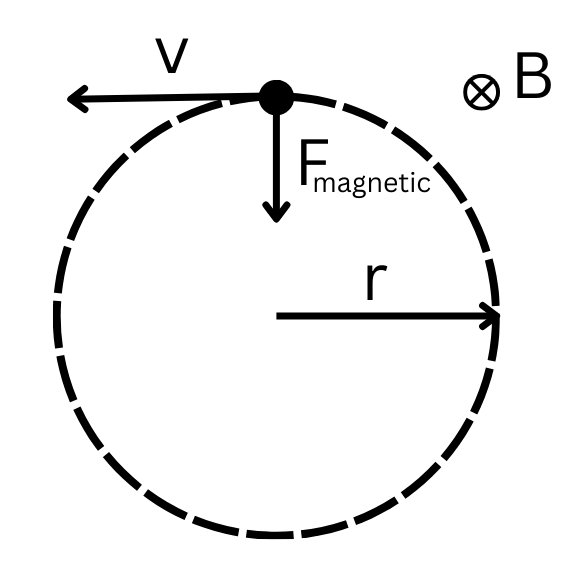

In the image shown above, there is a particle (at the top of the circle), moving with velocity $v$ through a magnetic field with strength $B$. The $\otimes$ symbol tells us that the magnetic field is pointing into the screen. The particle travels in the path given by the dotted line, which is a circle of radius $r$. At every point of the circle, the magnetic force, labelled $F_{magnetic}$ is pointed towards the center of the circle, as is shown above. The force is always perpendicular to both the velocity $v$ and the magnetic field $B$. This means it is possible for the force to point towards the center of the circle or away from the center of the circle, and this depends on the charge of the particle.

We can express the radius of the path as follows:

$$
r_{path} = \frac{|p_\perp|}{|q|B}
$$
where $r_{path}$ is the radius of the path, $|q|$ is the absolute value of the charge of the particle, and $B$ is the stregth of the magnetic field. $p_\perp$ is called the **transverse momentum**, and it refers to the components of the momentum that are perpendicular to the direction of the magnetic field. In the GlueX detector, the magnetic field points along the z axis, meaning:
$$
|p_\perp| = \sqrt{p_x^2+p_y^2}
$$
where $p_x$ is the x component of the momentum vector and $p_y$ is the y component of the momentum vector.

Since we know that the particle starts in the center of the detector, the path a particle takes can be entirely expressed in terms of $p_x$ and $p_y$.

Run the cell below to create a plot below of a cross section of the GlueX detector (as if you were looking in the z direction). The black circles represent the boundaries of the central drift chamber. You can modify the sliders to change the values of $p_x$ and $p_y$ to modify the track of the particle, shown in blue. You can also change the slider labelled t_max, which will change how long the track is. t_max is not a property of the track- it is only used for the visualization.

In [5]:
# @title
fig = CDC_plot("Track in the Gluex Detector",showTrack=True)
fig.update()
fig.display(fig.update_figure, px=(-1,1,0.0001),py=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2),show_track=fixed(True),show_hits=fixed(False),pz=fixed(0),z0=fixed(75))

#### **Question #6a:**
---
Change the charge of the simulated particle in the plot above. What about the path of the particle changes when you change the charge?

Double click to edit this cell and answer the following question: What about the path of the particle changes when you change the charge?

#####**Solution:**

Positively charged particles curve counterclockwise, while negatively charged particles curve clockwise. This is reflected in the equation for the magnetic force:
$$
F_{magnetic} = q*v\times B
$$
where $q$ is the charge, $v$ is the velocity vector, $B$ is the magnetic field vector, and $F_{magnetic}$ is the force vector. Particles with opposite charges experience forces in opposite directions, which cause them to curve in opposite directions. Note that $\times$ denotes the cross product, which is an operation between two vectors, not multiplication (which is an operation between two numbers).

#### **Question #6b:**
---
Based on your answer to the previous question, how can we determine the charge of a particle based on its track?

Double click to edit this cell and answer the following question: How can we determine the charge of a particle based on its track?

#####**Solution:**

We can determine the charge of a particle based on the direction it curves. If the particle's track curves counterclockwise, we know the particle must be positively charged. If it curves clockwise, we know the particle must be negatively charged. A neutral particle's track would not curve at all, but neutral particles do not leave tracks.

---
##**Track Fitting**
---

Track fitting is the process of figuring out the momentum vector of the particle pased on individual hits in the detector. There are several values that we need to find to adjust to get a good measurement of the momentum. In this section, we will explore how we can obtain the components of the momentum vector ($p_x$, $p_y$, and $p_z$), the charge of the particle, and the z coordinate of the vertex ($z_0$). While it is possible to obtain the other coordinates of the vertex ($x_0$ and $y_0$), it is very difficult to do manually, since they are usually smaller than a centimeter.

---
###**Step 1: Finding the Vertex**
---

In particle physics, a **vertex** is a place where particles are created. Whether the particles were created intentionally (by doing something to create them inside the "target") or through decays, the first step is to figure out where the particles came from. In other words, we want to find the coordinates of the vertex. Knowing the z coordinate of the vertex (often called $z_0$) is important because we can use it to estimate the z coordinate of the hits in the CDC, which is important because the the x and y coordinate of the hit depend on the z coordinate (see question #4).

For this activity, we will assume that the vertex is somewhere along the beam axis (the z axis), so the x and y coordinates of the vertex are both 0.

Below, we plotted the x and y coordinates of several hits left by a track in the GlueX CDC. However, you'll notice that the hits don't seem to line up to produce a smooth track. However, when you adjust the z coordinate of the vetex using the slider, you'll notice that you can update our estimate of the x and y coordinate of the hits in stereo rings (tilted rings). To find the best estimate of the z coordinate of the vertex (which gives us an estimate of the z codinates of the hits as well), we can adjust the slider until the points line up to form a smooth path.

In [6]:
# @title
i = 67223
fig = CDC_plot("Positions of Hits",track_fitting_events.iloc[i])
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=fixed(0),py=fixed(0),pz=fixed(0),show_hits=fixed(True),show_track=fixed(False),charge=fixed(1),t_max=fixed(1))

For example, the z coordinate of the vertex for the hits shown above are around 118. Note that this is just an estimate, so any z coordinate between 110 and 130 should allow you to get a good estimate of the momentum.

If the particle was moving in the z direction, the z coordinates of the hits could change as the particle moves through the detector. In these cases, it is impossible to find a $z_0$ value that lines up all of the points. This is the case in the example shown below. Try changing the value of $z_0$ to see that there is no "perfect" value for $z_0$! In these cases, just try your best to find a value of $z_0$ that allows you to estimate the path of the particle.

In [7]:
# @title
i = 70484
fig = CDC_plot("Positions of Hits",track_fitting_events.iloc[i])
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=fixed(0),py=fixed(0),pz=fixed(0),show_hits=fixed(True),show_track=fixed(False),charge=fixed(0),t_max=fixed(1))

In the example shown above, a $z_0$ value of about 63 should allow us to estimate the momentum. Again, this is just an estimate, so any value that is close to 63 should work just as well.

#### **Question #7:**
---
Every time you run the following cell, it will plot a new collection of hits with different z coordinates. Run the cell below and use the slider to find a good estimate of the z coordinate of the vertex of the track. Remember: if there is no value for $z_0$ that makes the hits perfectly line up, prioritize the hits closest to the center of the detector. Feel free to run this cell as many times as you need to practice finding the z values of the vertex in the CDC.

In [8]:
# @title
i = np.random.randint(0,len(track_fitting_events['ring']))
fig = CDC_plot("Positions of Hits",track_fitting_events.iloc[i])
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=fixed(0),py=fixed(0),pz=fixed(0),show_hits=fixed(True),show_track=fixed(False),charge=fixed(0),t_max=fixed(1))

#####**Solution:**

Run the cell below to calculate the z coordinate of the vertex for the hits shown above. Note that your value may be more accurate than the value produced by the following cell if there are multiple tracks (you can tell if there are multiple track if there are two different paths traced out by the hits) or if the hits don't form a line (sometimes, tracks just look like blobs, and we can't get much information from them). Things like this are easier for you to see than a computer to see!

In [9]:
# @title
fig.calc_z0()

The true z value is about 116.0


---
###**Step 2: Finding Charge and Transverse Momentum**
---

After our hits are lined up, we can fit the hits to a curve, which we calculate based on $p_x$ and $p_y$. Based on the direction of the curvature, we can find the charge of the particle as well.

The cell below creates an interactive plot with sliders for the following values:
*   $z_0$: The z coordinate of the vertex
*   $p_x$: The x component of the momentum
*   $p_y$: The y component of the momentum
*   The charge of the particle
*   $t_{max}$: the length of the track

First, use the slider below to adjust the z value until the track hits are lined up. Then, based on the direction the track curves, determine the charge of the particle. Finally, use the sliders to adjust $p_x$ and $p_y$ until the fitted track (the red line) passes through as many hit points as possible. Remember that you can use the t_max slider to increase or decrease the length of the track if necessary.

In [10]:
# @title
i = 87672
fig = CDC_plot("Hits in the Central Drift Chamber",track_fitting_events.iloc[i],showTrack=True)
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=(-1,1,0.01),py=(-1,1,0.01),pz=fixed(0),show_hits=fixed(True),show_track=fixed(True),charge=(-1,1,2),t_max=(0,2*np.pi,0.01))

In this case, we find that the z coordinate of the hits is $z=136$, the x component of the momentum is $p_x=-0.12$, the y component of the momentum is $p_y=0.03$, and the charge is -1. Note that we could turn t_max all the way up to 6.28 to see a longer track, which would be helpful if the hits formed a full circle instead of a semicircle.

#### **Question #8:**
---
Every time you run the following cell, it will plot a new collection of hits with different z coordinates for track with random momenta. Run the cell below and use the slider to find a good estimates of the z coordinate of the vertex, the x component of momentum, the y component of the momentum, and the charge. Feel free to run this cell as many times as you need to practice fitting tracks in the CDC.

In [11]:
# @title
i = np.random.randint(0,100000)
fig = CDC_plot("Hits in the Central Drift Chamber",track_fitting_events.iloc[i],showTrack=True)
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=(-1,1,0.01),py=(-1,1,0.01),pz=fixed(0),show_hits=fixed(True),show_track=fixed(True),charge=(-1,1,2),t_max=(0,2*np.pi,0.01))

#####**Solution:**

Run the cell below to calculate the z coordinate of the vertex, and the x and y coordinates of momentum ($p_x$ and $p_y$) for the hits shown above. Note that your value may be more accurate than the value produced by the following cell if there are multiple tracks (you can tell if there are multiple track if there are two different paths traced out by the hits) or if the hits don't form a line (sometimes, tracks just look like blobs, and we can't get much information from them). Things like this are easier for you to see than a computer to see!

Also, some of the tracks can't be fit using just the sliders shown above. Do you best to find a decent fit, but the next step will give you the tools to get almost perfect fits for every track.

In [12]:
# @title
fig.show_answer(every=True, but="pz")

The true z value is about 123.0
The charge of the particle is 1
The x component of momentum is -0.25
The y component of momentum is -0.5


---
###**Step 3: Finding Momentum in Z direction**
---

So far, we have not provided any information about the $z$ component of the momentum ($p_z$). If the $z$ component of the momentum vector is 0, that means that the particle is not moving in the z direction at all, which means that all of the hits should have the same z coordinate. However, if $p_z$ is not zero then the particle is moving in the z direction, which means the z coordinates of the hits should change as the particle passes through the detector. For example, the first hit may have a z coordinate of 70, while the last hit has a z coordinate of 80. This is what may cause a track to not line up, even if we have the correct z coordinate of the vertex. To fix, this, we adjust the z coordinate of hits that occur later in the track based on the momentum in the z direction.

The plot below shows the correct track for the hits shown below. Change the value of $p_z$ in the plot below to see its effect on the track hits. Try to find the value of $p_z$ that causes the points to align.

In [13]:
# @title
i = 75602
fig = CDC_plot("Hits in the Central Drift Chamber",track_fitting_events.iloc[i],showTrack=True)
fig.update()
fig.display(fig.update_figure, z0=fixed(118.6),px=fixed(fig.px),py=fixed(fig.py),pz=(-1,1,0.01),show_hits=fixed(True),show_track=fixed(True),charge=fixed(fig.charge),t_max=fixed(0.75))

The hits shown above have a z momentum of about -0.59. Notice how the hits furthest from the center of the detector are affected the most by the $p_z$ slider. This is because the hits that are further from the center of the detector happen after the hits close to the center of the detector (since the particle moves from the center of the detector outward). Also, the z component of the momentum of the particle causes the z component of the hits to change over time. Since the hits furthest from the center of the detector occur much later than the hits near the center, their z coordinates have the most time to change. This change in z coordinates make the hits seem like they are moving (see problem 5).

Even though we only changed the value of $p_z$ above, we usually have to go back and forth, slightly modifying both the $z_0$ slider and the $p_z$ slider, to find their true values- this is why we only estimated the z coordinate of the vertex ($z_0$) in step 1. Try to find the true $z_0$ value and $p_z$ value in the example below. To do this, first estimate the z coordinate of the vertext ($z_0$), then go back and forth between changing the z coordinate of the vertex ($z_0$) and the z component of the momentum ($p_z$).

In [14]:
# @title
i = 22699
fig = CDC_plot("Hits in the Central Drift Chamber",track_fitting_events.iloc[i],showTrack=True)
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=fixed(fig.px),py=fixed(fig.py),pz=(-1,1,0.01),show_hits=fixed(True),show_track=fixed(True),charge=fixed(fig.charge),t_max=fixed(0.75))

For the example above, setting the z coordinate of the vertex ($z_0$) to 123 and the z component of the momentum ($p_z$) to -0.42 will create a very smooth track. This step is subtantially harder than the other two steps: There seem to be multiple values that seem to produce similar results! For example, setting the z coordinate of the vertex ($z_0$) to 126 and the z component of the momentum ($p_z$) to -0.52 seems to yield almost the exact same results. It's almost impossible to pick which one is correct, which limits our ability to make extremely precise measurements of the vertex coordinates and z component of momentum.

####**Question #9:**
---
When you adjust the $p_z$ and $z_0$ sliders, there are certain hits that do not move. What is special about these wires? **Hint:** You can hover your mouse over hits to see what ring they belong to in the interactive plots.


Double click to edit this cell and answer the following question: What is special about these wires?

#####**Solution:**

The hits that do not move are hits in axial (not tilted) wires. See questions 4 and 5 for more information about axial and stereo wires. Because the axial wires are lined up with the z axis, their x and y coordinates do not change for different z coordinates. The hits that do move are in stereo wires, whose x and y coordinates do change as we change the z coordinate changes (when we move the $z_0$ or the $p_z$ slider).

#### **Question #10:**
---
Every time you run the following cell, it will plot a new collection of hits with different z coordinates for track with random momenta. Run the cell below and use the slider to find a good estimate of the z coordinate of the hits, the x component of momentum, the y component of the momentum, and the charge. Feel free to run this cell as many times as you need to practice fitting tracks in the CDC.

In [15]:
# @title
i = np.random.randint(0,100000)
fig = CDC_plot("Hits in the Central Drift Chamber",track_fitting_events.iloc[i],showTrack=True)
fig.update()
fig.display(fig.update_figure, z0=(0,175,0.1),px=(-1,1,0.01),py=(-1,1,0.01),pz=(-1,1,0.01),show_hits=fixed(True),show_track=fixed(True),charge=(-1,1,2),t_max=(0,2*np.pi,0.01))

#####**Solution:**

Run the cell below to see the best values for the z coordinate of the vertex ($z_0$), the components of the momentum ($p_x$, $p_y$, and $p_z$), and the charge. If the hits are just a blob (instead of a line) or there are multiple tracks (meaning there seem to be multiple lines of hits), these values may not be accurate.

In [16]:
# @title
fig.show_answer(every=True)

The true z value is about 16.0
The charge of the particle is 1
The x component of momentum is 0.07
The y component of momentum is -0.06
The z component of momentum is 0.45
